In [1]:
import numpy as np
import matplotlib.pyplot as plt
import folie as fl
import csv
from copy import deepcopy


1D UNBIASED Double Well Potential
==

## 1) The model 


Here we model the double well potential as a quartic function $V(q)= \sum_{i=0}^4 c_iq^i$ and choose a constant diffusion coefficient $D(q)=q$ :

The force parameter to pass to the simulator will then be : $F = - \frac{dV(q)}{dq}$

In [2]:
coeff=0.1*np.array([0,0,-4.5,0,0.1]) # coefficients of the free energy
free_energy = np.polynomial.Polynomial(coeff)
force_coeff=np.array([-coeff[1],-2*coeff[2],-3*coeff[3],-4*coeff[4]]) #coefficients of the free energy
force_function = fl.functions.Polynomial(deg=3,coefficients=force_coeff)
diff_function= fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.5]))

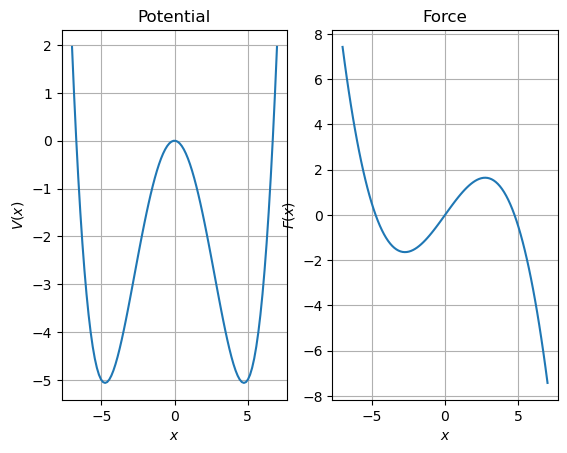

In [3]:
# Plot of Free Energy and Force
x_values = np.linspace(-7, 7, 100)
fig, axs = plt.subplots(1, 2)
axs[0].plot(x_values,free_energy(x_values))
axs[1].plot(x_values,force_function(x_values.reshape(len(x_values),1)))
axs[0].set_title("Potential")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$V(x)$")
axs[0].grid()
axs[1].set_title("Force") 
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$F(x)$") 
axs[1].grid()

## 2) Simulation

In [4]:
# Define model to simulate and type of simulator to use
dt=1e-3
model_simu = fl.models.overdamped.Overdamped(force_function,diffusion=diff_function)
simulator = fl.simulations.Simulator(fl.simulations.EulerStepper(model_simu), dt) #, k=0.0, xstop=6.0)

In [5]:
ntraj=30
q0= np.empty(ntraj)
for i in range(len(q0)):
    q0[i]=0
# Calculate Trajectory
time_steps=10000
data = simulator.run(time_steps, q0, 1)

In [24]:
len(data)

30

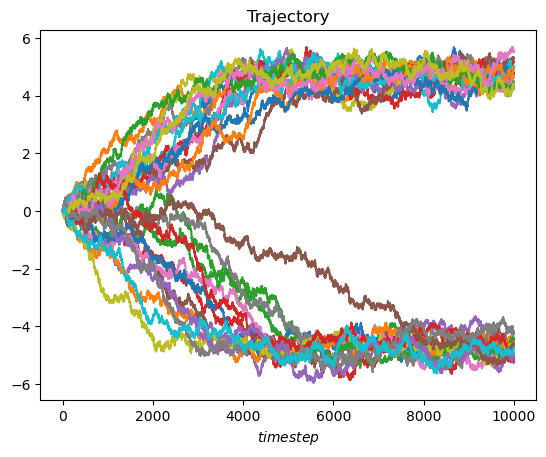

In [6]:
# Plot the trajecories
fig, axs = plt.subplots(1,1)
for n, trj in enumerate(data):
    axs.plot(trj["x"])
    axs.set_title("Trajectory")
    axs.set_xlabel("$timestep$")

## 3) Model Training 

#\# Parameters of the training
trainforce =fl.functions.Polynomial(deg=3,coefficients=np.asarray([1,1,1,1]))
traindiff = fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.0]))
#\# trainmodel=fl.models.Overdamped(force = trainforce,diffusion=traindiff, has_bias=False)
trainmodel= fl.models.OverdampedSplines1D(domain=domain)

fig, axs = plt.subplots(1, 2)
axs[0].set_title("Force")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$F(x)$")
axs[0].grid()

axs[1].set_title("Diffusion")
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$D(x)$")
axs[1].grid()


xfa = np.linspace(-7.0, 7.0, 75)

axs[0].plot(xfa, model_simu.force(xfa.reshape(-1, 1)), label="Exact")
axs[1].plot(xfa, model_simu.diffusion(xfa.reshape(-1, 1)), label="Exact")
for name, transitioncls in zip(
    ["Euler", "Ozaki", "ShojiOzaki", "Elerian", "Kessler", "Drozdov"],
    [
        fl.EulerDensity,
        fl.OzakiDensity,
        fl.ShojiOzakiDensity,
        fl.ElerianDensity,
        fl.KesslerDensity,
        fl.DrozdovDensity,
    ],
):
    estimator = fl.LikelihoodEstimator(transitioncls(fl.models.OverdampedSplines1D(domain=domain)))
    res = estimator.fit_fetch(data)
    print(res.coefficients)
    # res.remove_bias()
    axs[0].plot(xfa, res.force(xfa.reshape(-1, 1)), label=name)
    axs[1].plot(xfa, res.diffusion(xfa.reshape(-1, 1)), label=name)
axs[0].legend()
axs[1].legend()
plt.show()

### 3.1) Training using same functional form of true force and diffusion 

In [ ]:
# Parameters of the training
trainforce =fl.functions.Polynomial(deg=3,coefficients=np.asarray([1,1,1,1]))
traindiff = fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.0]))

trainmodel=fl.models.Overdamped(force = trainforce,diffusion=traindiff)

Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodel)))  # deepcopy is used because the estimator modifies the model when fit method is called
Ozk_estimator = fl.LikelihoodEstimator(fl.OzakiDensity(deepcopy(trainmodel)))  # and when the second estimator uses the object trainmodel this will already have the modfications
Shj_estimator = fl.LikelihoodEstimator(fl.ShojiOzakiDensity(deepcopy(trainmodel))) # made by the previuos estimatorand so in the end they will return the exact same results
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodel)))  # which is the reason why the loop checking if the values are different in the following cell exists
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodel)))
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodel)))

Eul_res=Eul_estimator.fit_fetch(data)
Ozk_res=Ozk_estimator.fit_fetch(data)
Shj_res=Shj_estimator.fit_fetch(data)
Eln_res=Eln_estimator.fit_fetch(data)
Ksl_res=Ksl_estimator.fit_fetch(data)
Drz_res=Drz_estimator.fit_fetch(data)

res_vec = [Eul_res,Ozk_res,Shj_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 


/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:191: RuntimeWarning: invalid value encountered in sqrt
  Vt = np.sqrt(sig * (np.exp(Kt * dt) - 1) / Kt)
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:190: RuntimeWarning: invalid value encountered in log
  Kt = (2 / dt) * np.log(1 + temp / x.ravel())
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:212: RuntimeWarning: invalid value encountered in sqrt
  sig = np.sqrt(self._model.diffusion(x, **kwargs).ravel())
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:221: RuntimeWarning: overflow encountered in exp
  B = sig * np.sqrt((np.exp(2 * Lt * dt) - 1) / (2 * Lt))
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:223: RuntimeWarning: overflow encountered in exp
  elt = np.exp(Lt * dt) - 1
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:224: RuntimeWarning: overflow encountered in multiply
  A = x.ravel() + mu /

[ 0.12326394  0.92978574 -0.00912699 -0.04178302  0.50116262]
[ 1.23533140e-04  9.29629983e-04 -9.14577286e-06 -4.17755609e-05
  5.01926907e-01]
[ 1.23533140e-04  9.29629983e-04 -9.14577286e-06 -4.17755609e-05
  5.01926907e-01]
[ 0.12325752  0.92981884 -0.00912754 -0.04178445  0.50116317]
[ 0.12280816  0.9281888  -0.00910943 -0.04171053  0.50166357]
[ 0.12319667  0.9293784  -0.00912934 -0.04176292  0.50166507]


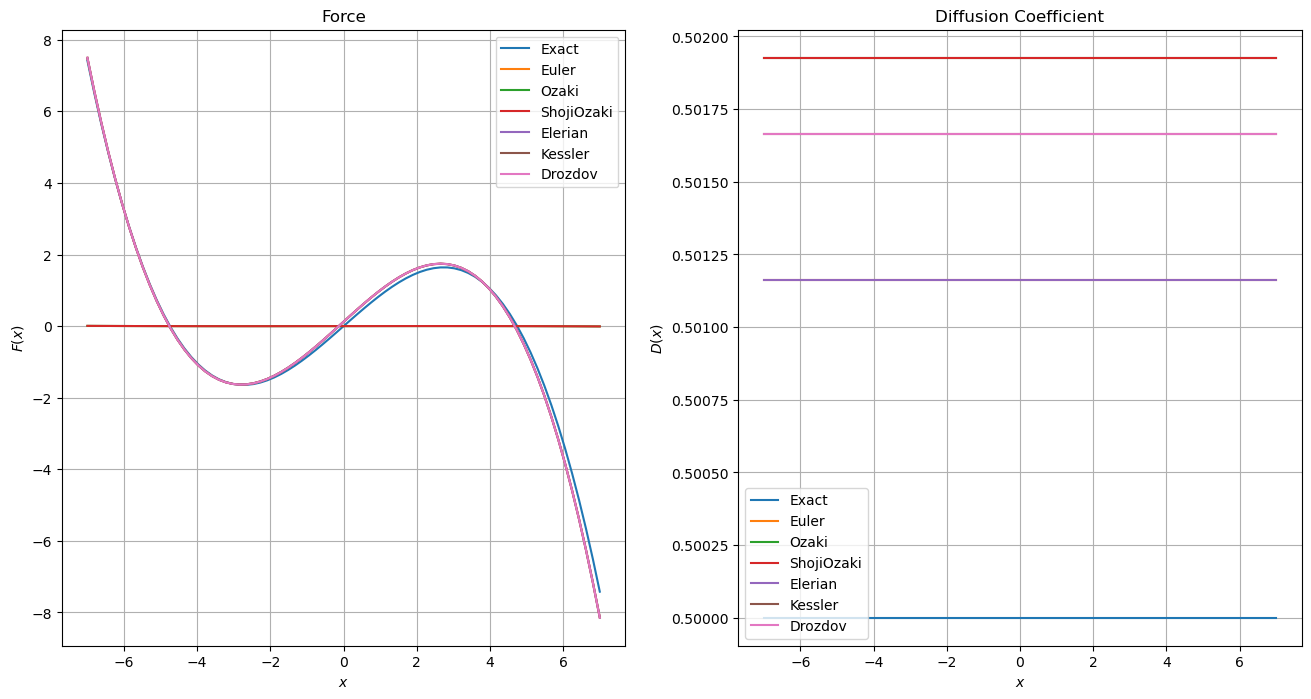

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].set_title("Force")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$F(x)$")
axs[0].grid()

axs[1].set_title("Diffusion Coefficient")
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$D(x)$") 
axs[1].grid()
xfa = np.linspace(-7.0, 7.0, 75)

#Plot exact quantities 
axs[0].plot(xfa, model_simu.force(xfa.reshape(-1, 1)), label="Exact")
axs[1].plot(xfa, model_simu.diffusion(xfa.reshape(-1, 1)), label="Exact")
#Plot inferred quantities 
names = ["Euler", "Ozaki", "ShojiOzaki", "Elerian", "Kessler", "Drozdov"]
for i in range(len(names)):
    axs[0].plot(xfa, res_vec[i].force(xfa.reshape(-1, 1)), label=names[i] )
    axs[1].plot(xfa, res_vec[i].diffusion(xfa.reshape(-1, 1)), label=names[i])
    print(res_vec[i].coefficients)
axs[0].legend()
axs[1].legend()



Check if the methods are returning all the the same results

In [ ]:
for i in range(len(names)-1):
    flag_force= (res_vec[i].force(xfa.reshape(-1, 1)) == res_vec[i+1].force(xfa.reshape(-1, 1))).all()
    flag_diff= (res_vec[i].diffusion(xfa.reshape(-1, 1)) == res_vec[i+1].diffusion(xfa.reshape(-1, 1))).all()
    print(flag_force, flag_diff)  # apparently they are 

False False
True True
False False
False False
False False


### 3.2) Training using splines

In [8]:
# Parameters of the training

domain = fl.MeshedDomain.create_from_range(np.linspace(data.stats.min , data.stats.max , 10).ravel())
trainmodel = fl.models.OverdampedSplines1D(domain=domain)

Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodel)))
Ozk_estimator = fl.LikelihoodEstimator(fl.OzakiDensity(deepcopy(trainmodel)))
Shj_estimator = fl.LikelihoodEstimator(fl.ShojiOzakiDensity(deepcopy(trainmodel)))
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodel)))
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodel)))
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodel)))

Eul_res=Eul_estimator.fit_fetch(data)
Ozk_res=Ozk_estimator.fit_fetch(data)
Shj_res=Shj_estimator.fit_fetch(data)
Eln_res=Eln_estimator.fit_fetch(data)
Ksl_res=Ksl_estimator.fit_fetch(data)
Drz_res=Drz_estimator.fit_fetch(data)

res_vec = [Eul_res,Ozk_res,Shj_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 


/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:191: RuntimeWarning: invalid value encountered in sqrt
  Vt = np.sqrt(sig * (np.exp(Kt * dt) - 1) / Kt)
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:190: RuntimeWarning: invalid value encountered in log
  Kt = (2 / dt) * np.log(1 + temp / x.ravel())
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:212: RuntimeWarning: invalid value encountered in sqrt
  sig = np.sqrt(self._model.diffusion(x, **kwargs).ravel())
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:221: RuntimeWarning: overflow encountered in exp
  B = sig * np.sqrt((np.exp(2 * Lt * dt) - 1) / (2 * Lt))
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:223: RuntimeWarning: overflow encountered in exp
  elt = np.exp(Lt * dt) - 1
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:224: RuntimeWarning: overflow encountered in multiply
  A = x.ravel() + mu /

In [ ]:
res_vec[].force

SyntaxError: invalid syntax (181384796.py, line 1)

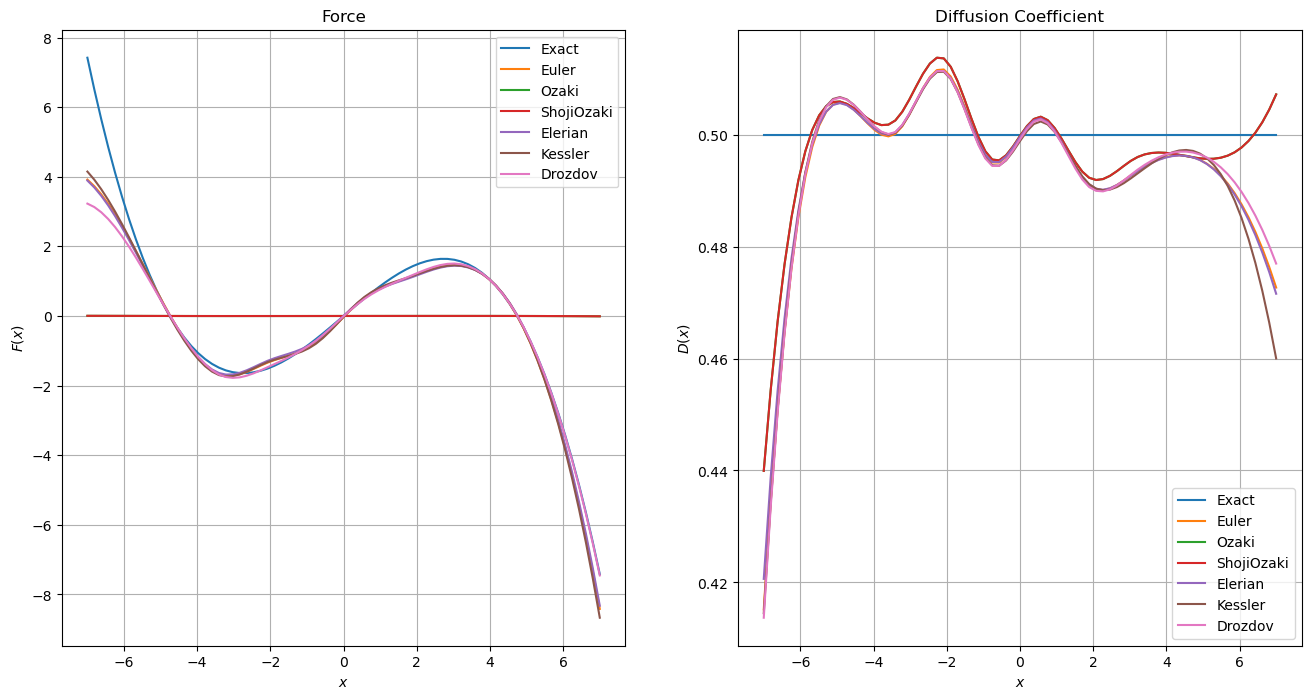

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
# axs.set_title("training using splines and 30 trajectories ")
axs[0].set_title("Force")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$F(x)$")
axs[0].grid()

axs[1].set_title("Diffusion Coefficient")
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$D(x)$") 
axs[1].grid()
xfa = np.linspace(-7.0, 7.0, 75)

#Plot exact quantities 
axs[0].plot(xfa, model_simu.force(xfa.reshape(-1, 1)), label="Exact")
axs[1].plot(xfa, model_simu.diffusion(xfa.reshape(-1, 1)), label="Exact")
#Plot inferred quantities 
names = ["Euler", "Ozaki", "ShojiOzaki", "Elerian", "Kessler", "Drozdov"]
for i in range(len(names)):
    axs[0].plot(xfa, res_vec[i].force(xfa.reshape(-1, 1)), label=names[i] )
    axs[1].plot(xfa, res_vec[i].diffusion(xfa.reshape(-1, 1)), label=names[i])
axs[0].legend()
axs[1].legend()

Check if the methods are returning all the the same results

In [ ]:
for i in range(len(names)-1):
    flag_force= (res_vec[i].force(xfa.reshape(-1, 1)) == res_vec[i+1].force(xfa.reshape(-1, 1))).all()
    flag_diff= (res_vec[i].diffusion(xfa.reshape(-1, 1)) == res_vec[i+1].diffusion(xfa.reshape(-1, 1))).all()
    print(flag_force, flag_diff)  # apparently they are 

False False
True True
False False
False False
False False


[ 5.93779812 21.61172333 21.61172333  6.16690615  6.46510623  6.41053799]


False

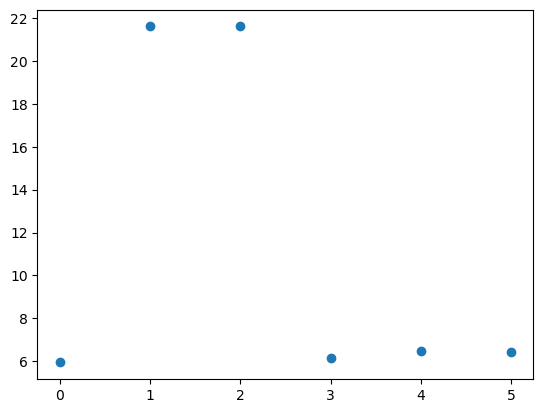

In [ ]:
rmsd_force=np.array([ np.linalg.norm(model_simu.force(xfa.reshape(-1, 1))-Eul_res.force(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.force(xfa.reshape(-1, 1))-Ozk_res.force(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.force(xfa.reshape(-1, 1))-Shj_res.force(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.force(xfa.reshape(-1, 1))-Eln_res.force(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.force(xfa.reshape(-1, 1))-Ksl_res.force(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.force(xfa.reshape(-1, 1))-Drz_res.force(xfa.reshape(-1, 1)))  ])

rmsd_diffusion=np.array([np.linalg.norm(model_simu.diffusion(xfa.reshape(-1, 1))-Eul_res.diffusion(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.diffusion(xfa.reshape(-1, 1))-Ozk_res.diffusion(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.diffusion(xfa.reshape(-1, 1))-Shj_res.diffusion(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.diffusion(xfa.reshape(-1, 1))-Eln_res.diffusion(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.diffusion(xfa.reshape(-1, 1))-Ksl_res.diffusion(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.diffusion(xfa.reshape(-1, 1))-Drz_res.diffusion(xfa.reshape(-1, 1)))  ])

# plt.scatter(np.arange(len(rmsd_force)),rmsd_force)

plt.scatter(np.arange(len(rmsd_force)),rmsd_force)
print(rmsd_force)
flag =True
for i in range(len(rmsd_force)-1):
    if rmsd_force[i] != rmsd_force[i+1]:
        flag = False
flag

1D BIASED Double Well Potential
==

## 1) Model

Here we model the double well potential as a quartic function $V(q)= \sum_{i=0}^4 c_iq^i$ and choose a constant diffusion coefficient $D(q)=D$ : $\newline$
The force parameter to pass to the simulator will then be : $F = - \frac{dV(q)}{dq}$   $\newline$
Adiabaic bias used : $V_{bias}(q)=\frac{1}{2}k(q-q_0)^2  \longmapsto$ ABMD_Simulator $\newline$
The center of the parabola, $q_0$, is choosen as : $max(q,q_0)$ at every iteration 

In [ ]:
coeff=0.1*np.array([0,0,-4.5,0,0.1]) # coefficients of the free energy
free_energy = np.polynomial.Polynomial(coeff)
force_coeff=np.array([-coeff[1],-2*coeff[2],-3*coeff[3],-4*coeff[4]]) #coefficients of the free energy
force_function = fl.functions.Polynomial(deg=3,coefficients=force_coeff)
diff_function= fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.5]))

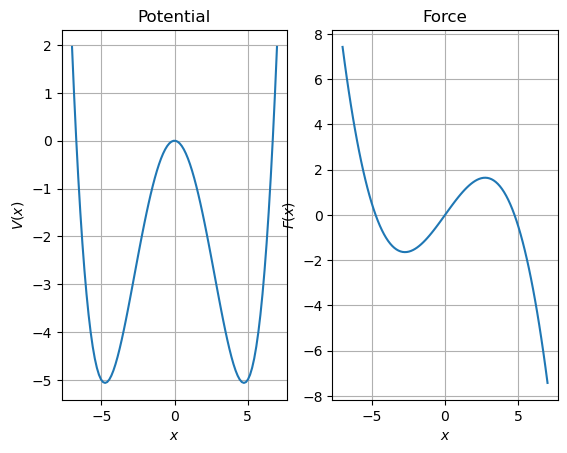

In [ ]:
# Plot of Free Energy and Force
x_values = np.linspace(-7, 7, 100)
fig, axs = plt.subplots(1, 2)
axs[0].plot(x_values,free_energy(x_values))
axs[1].plot(x_values,force_function(x_values.reshape(len(x_values),1)))
axs[0].set_title("Potential")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$V(x)$")
axs[0].grid()
axs[1].set_title("Force") 
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$F(x)$") 
axs[1].grid()

## 2) Simulation

In [ ]:
# Define model to simulate and type of simulator to use
dt=1e-3
biased_model_simu = fl.models.overdamped.Overdamped(force_function,diffusion=diff_function)
biased_simulator = fl.simulations.ABMD_Simulator(fl.simulations.EulerStepper(biased_model_simu), dt, k=5.0, xstop=6.0) 
ntraj=30
q0= np.empty(ntraj)
for i in range(len(q0)):
    q0[i]=0
# Calculate Trajectory
time_steps=5000
biased_data = biased_simulator.run(time_steps, q0, 1)
xmax = np.concatenate(biased_simulator.xmax_hist, axis=1).T    # if you rerun simulator.run without reinializing the simulator object it will probably append the results making xmax twice as long 

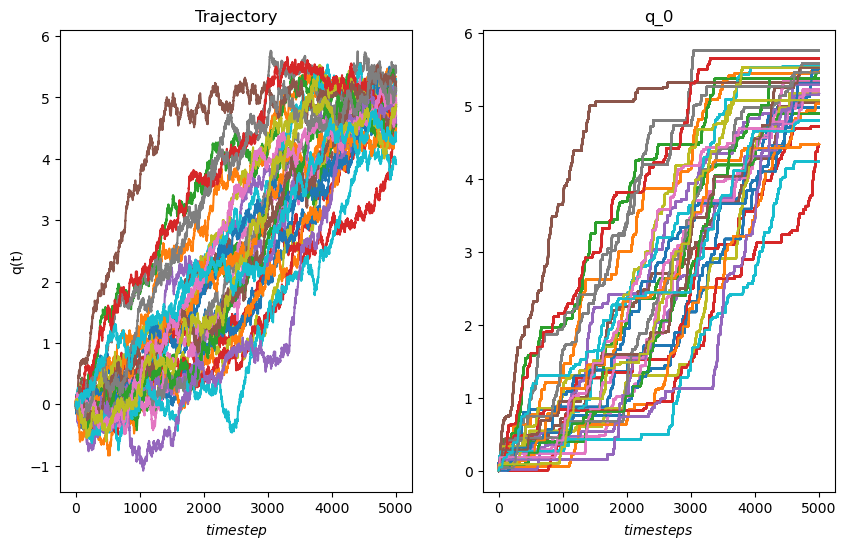

In [ ]:
# Plot the trajecories
fig, axs = plt.subplots(1,2,figsize=(10,6))
for n, trj in enumerate(biased_data):
    axs[0].plot(trj["x"])
    axs[0].set_title("Trajectory")
    axs[0].set_xlabel("$timestep$")
    axs[0].set_ylabel("q(t)")
    axs[1].plot(xmax)
    axs[1].set_title("q_0")
    axs[1].set_xlabel("$timesteps$")



## 3) Model Training 

### 3.1) Training using same functional form of true force and diffusion 

In [ ]:
# Parameters of the training

trainforce =fl.functions.Polynomial(deg=3,coefficients=np.asarray([1,1,1,1]))
traindiff = fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.0]))
trainmodel=fl.models.Overdamped(force = trainforce,diffusion=traindiff, has_bias=True)

Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodel)))
Ozk_estimator = fl.LikelihoodEstimator(fl.OzakiDensity(deepcopy(trainmodel)))
Shj_estimator = fl.LikelihoodEstimator(fl.ShojiOzakiDensity(deepcopy(trainmodel)))
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodel)))
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodel)))
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodel)))

Eul_res=Eul_estimator.fit_fetch(data)
Ozk_res=Ozk_estimator.fit_fetch(data)
Shj_res=Shj_estimator.fit_fetch(data)
Eln_res=Eln_estimator.fit_fetch(data)
Ksl_res=Ksl_estimator.fit_fetch(data)
Drz_res=Drz_estimator.fit_fetch(data)

Eul_res.remove_bias()
Ozk_res.remove_bias()
Shj_res.remove_bias()
Eln_res.remove_bias()
Ksl_res.remove_bias()
Drz_res.remove_bias()

res_vec = [Eul_res,Ozk_res,Shj_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 


RecursionError: maximum recursion depth exceeded

In [ ]:
# trainmodel_simu = biased_model_simu
# trainmodel_simu.remove_bias()

Model is not biased


TypeError: FunctionOffset.__call__() missing 1 required positional argument: 'v'

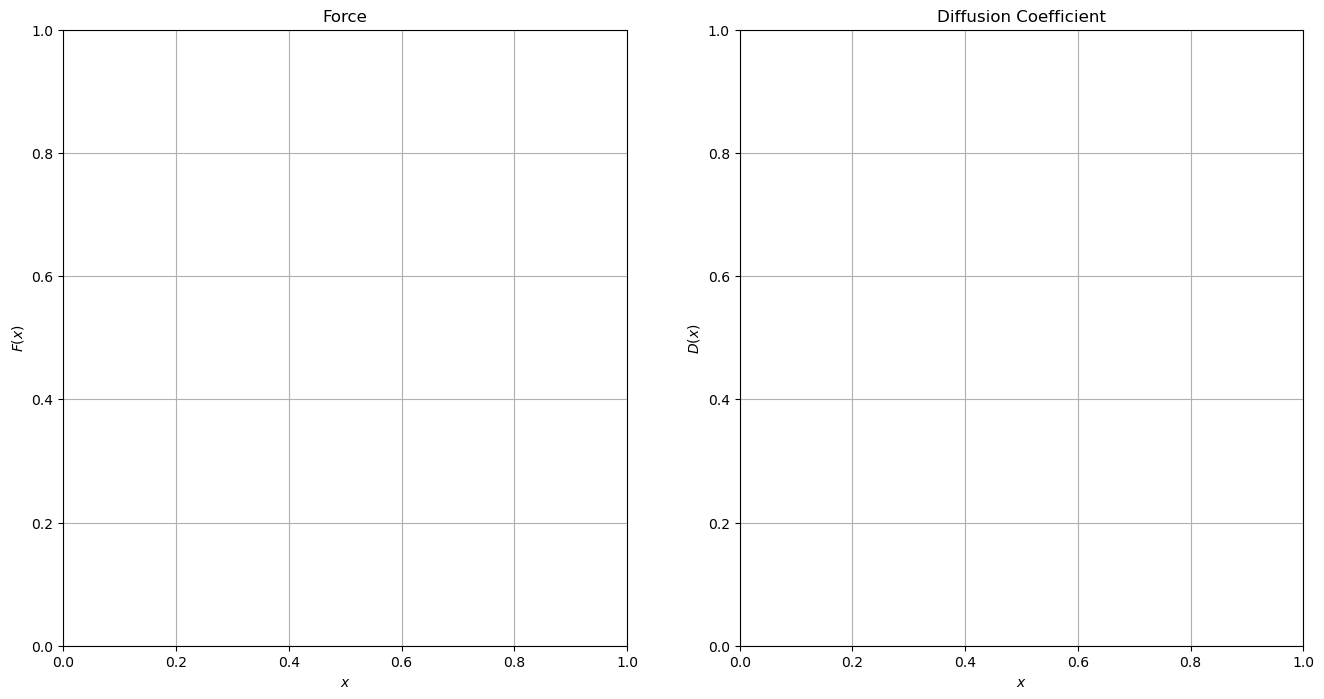

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].set_title("Force")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$F(x)$")
axs[0].grid()

axs[1].set_title("Diffusion Coefficient")
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$D(x)$") 
axs[1].grid()
xfa = np.linspace(-7.0, 7.0, 75)

#Plot exact quantities 
axs[0].plot(xfa, biased_model_simu.force(xfa.reshape(-1, 1)), label="Exact")
axs[1].plot(xfa, biased_model_simu.diffusion(xfa.reshape(-1, 1)), label="Exact")
#Plot inferred quantities 
names = ["Euler", "Ozaki", "ShojiOzaki", "Elerian", "Kessler", "Drozdov"]
for i in range(len(names)):
    axs[0].plot(xfa, res_vec[i].force(xfa.reshape(-1, 1)), label=names[i] )
    axs[1].plot(xfa, res_vec[i].diffusion(xfa.reshape(-1, 1)), label=names[i])
axs[0].legend()
axs[1].legend()


In [ ]:

rmsd_force=np.array([ np.linalg.norm(model_simu.force(xfa.reshape(-1, 1))-Eul_res.force(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.force(xfa.reshape(-1, 1))-Ozk_res.force(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.force(xfa.reshape(-1, 1))-Shj_res.force(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.force(xfa.reshape(-1, 1))-Eln_res.force(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.force(xfa.reshape(-1, 1))-Ksl_res.force(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.force(xfa.reshape(-1, 1))-Drz_res.force(xfa.reshape(-1, 1)))  ])

rmsd_diffusion=np.array([np.linalg.norm(model_simu.diffusion(xfa.reshape(-1, 1))-Eul_res.diffusion(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.diffusion(xfa.reshape(-1, 1))-Ozk_res.diffusion(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.diffusion(xfa.reshape(-1, 1))-Shj_res.diffusion(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.diffusion(xfa.reshape(-1, 1))-Eln_res.diffusion(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.diffusion(xfa.reshape(-1, 1))-Ksl_res.diffusion(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.diffusion(xfa.reshape(-1, 1))-Drz_res.diffusion(xfa.reshape(-1, 1)))  ])

# plt.scatter(np.arange(len(rmsd_force)),rmsd_force)

plt.scatter(np.arange(len(rmsd_diffusion)),rmsd_diffusion)
print(rmsd_diffusion)

TypeError: FunctionOffset.__call__() missing 1 required positional argument: 'v'

### 3.2) Training using splines

In [ ]:
# Parameters of the training

domain = fl.MeshedDomain.create_from_range(np.linspace(data.stats.min , data.stats.max , 10).ravel())
trainmodel = fl.models.OverdampedSplines1D(domain=domain)

Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(trainmodel))
Ozk_estimator = fl.LikelihoodEstimator(fl.OzakiDensity(trainmodel))
Shj_estimator = fl.LikelihoodEstimator(fl.ShojiOzakiDensity(trainmodel))
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(trainmodel))
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(trainmodel))
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(trainmodel))

Eul_res=Eul_estimator.fit_fetch(data)
Ozk_res=Ozk_estimator.fit_fetch(data)
Shj_res=Shj_estimator.fit_fetch(data)
Eln_res=Eln_estimator.fit_fetch(data)
Ksl_res=Ksl_estimator.fit_fetch(data)
Drz_res=Drz_estimator.fit_fetch(data)

res_vec = [Eul_res,Ozk_res,Shj_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 


/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:191: RuntimeWarning: invalid value encountered in sqrt
  Vt = np.sqrt(sig * (np.exp(Kt * dt) - 1) / Kt)
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:190: RuntimeWarning: invalid value encountered in log
  Kt = (2 / dt) * np.log(1 + temp / x.ravel())
/home/dbersano/folie/folie/estimation/transitionDensity.py:11: RuntimeWarning: overflow encountered in square
  return -0.5 * ((xt.ravel() - E) ** 2 / V) - 0.5 * np.log(np.sqrt(2 * np.pi) * V)
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:212: RuntimeWarning: invalid value encountered in sqrt
  sig = np.sqrt(self._model.diffusion(x, **kwargs).ravel())
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:221: RuntimeWarning: overflow encountered in exp
  B = sig * np.sqrt((np.exp(2 * Lt * dt) - 1) / (2 * Lt))
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:223: RuntimeWarning: overflow 

# 2D UNBIASED Double Well Potential

attempt ornstein uhlembeck
==

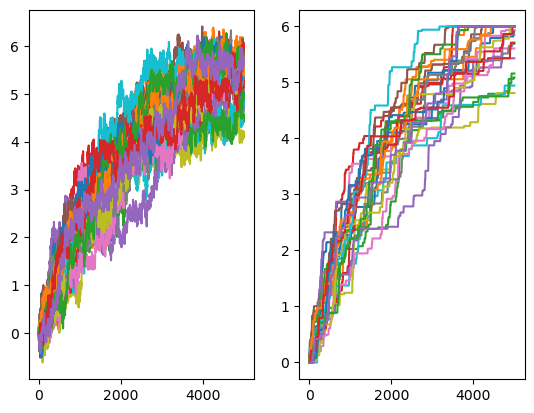

In [ ]:

model_simu = fl.models.OrnsteinUhlenbeck(0.0, 1.2, 2.0)
simulator = fl.simulations.ABMD_Simulator(fl.simulations.EulerStepper(model_simu), 1e-3, k=10.0, xstop=6.0)
data = simulator.run(5000, np.zeros((25,)), 1)
xmax = np.concatenate(simulator.xmax_hist, axis=1).T

# Plot the resulting trajectories
# sphinx_gallery_thumbnail_number = 1
fig, axs = plt.subplots(1, 2)
for n, trj in enumerate(data):
    axs[0].plot(trj["x"])
    axs[1].plot(xmax[:, n])

In [ ]:

# model_simu = fl.models.OrnsteinUhlenbeck(0.0, 1.2, 2.0)
# simulator = fl.simulations.ABMD_Simulator(fl.simulations.EulerStepper(model_simu), 1e-3, k=10.0, xstop=6.0)
# data = simulator.run(5000, np.zeros((25,)), 1)
# xmax = np.concatenate(simulator.xmax_hist, axis=1).T
# model_simu.remove_bias()
trainmodel=fl.models.OrnsteinUhlenbeck(has_bias=True)

Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodel)))  # deepcopy is used because the estimator modifies the model when fit method is called
Ozk_estimator = fl.LikelihoodEstimator(fl.OzakiDensity(deepcopy(trainmodel)))  # and when the second estimator uses the object trainmodel this will already have the modfications
Shj_estimator = fl.LikelihoodEstimator(fl.ShojiOzakiDensity(deepcopy(trainmodel))) # made by the previuos estimatorand so in the end they will return the exact same results
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodel)))  # which is the reason why the loop checking if the values are different in the following cell exists
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodel)))
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodel)))

Eul_res=Eul_estimator.fit_fetch(data)
Ozk_res=Ozk_estimator.fit_fetch(data)
Shj_res=Shj_estimator.fit_fetch(data)
Eln_res=Eln_estimator.fit_fetch(data)
Ksl_res=Ksl_estimator.fit_fetch(data)
Drz_res=Drz_estimator.fit_fetch(data)

res_vec = [Eul_res,Ozk_res,Shj_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 


RecursionError: maximum recursion depth exceeded